<a href="https://colab.research.google.com/github/acfrank-24/final-project/blob/main/Final_Project_acf2181.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Federal Reserve Testimony

##Table of Contents

>[Analyzing Federal Reserve Testimony](#scrollTo=m_ReK7d-nqad)

>>[Table of Contents](#scrollTo=cgfeDwmJCpDh)

>>[Introduction](#scrollTo=uvEQkAZT8Z50)

>>>[Motivation](#scrollTo=HB8FITcm3Nzu)

>>>[Research Question](#scrollTo=HB8FITcm3Nzu)

>>>[Hypotheses](#scrollTo=HB8FITcm3Nzu)

>>[Methods](#scrollTo=DaBRRrvSCep0)

>>>[Data Collection](#scrollTo=SbmizYOq7DF-)

>>>>[Webscraping Text](#scrollTo=dW-iEEBJn4r8)

>>>>[Data Cleaning for Question Analysis](#scrollTo=q0Wvtn_Wn_aZ)

>>>[Data Analysis](#scrollTo=KSnswtx9F7_Y)

>>>>[Topic Modelling](#scrollTo=ZQ-e-BuQ8UqS)

>>>>[TF-IDF](#scrollTo=3qlsmWE_Ggv1)

>>[Results and Discussion](#scrollTo=GXp8ctQ08b0p)

>>>[Topic Modelling](#scrollTo=vYMLuAj2ghgI)

>>>[TF-IDF](#scrollTo=1dnkuleVA-RJ)

>>>[Other Text Analysis](#scrollTo=ro5QfNzzOAkL)

>>[Conclusion](#scrollTo=HHTghWAw8hhC)

>>>[Next Steps](#scrollTo=HHTghWAw8hhC)



##Introduction


###Motivation

Under the Federal Reserve Act, the Federal Reserve (Fed) Board Chair is required to present the Fed’s semi-annual Monetary Policy Report (MPR) to the Senate Committee on Banking, Housing, and Urban Affairs and to the House Committee on Financial Services ([Federal Reserve, 2023](https://www.federalreserve.gov/monetarypolicy/publications/mpr_default.htm )). The MPR covers recent economic and financial developments, monetary policy decisions, and economic projections.

The Fed Chair, currently Jerome Powell, is required to testify at the hearings. Each testimony begins with an opening statement from the Committee Chair, followed by the Fed Chair's prepared remarks, then questions from the Committee members. The hearings take place on consecutive days, generally in February and July. The Fed Chair prepares one statement related to the MPR, and presents identical remarks in front of each committee. The hearings provide an important opportunity for Congress to hold the Fed accountable for its monetary policy decisions ([Federal Reserve, 2019](https://www.federalreserve.gov/faqs/about_12798.htm)).


###Research Question
How well does Congress hold the Fed to account?

This project will use text analysis tools to analyze the congressional hearing transcripts from the semi-annual testimonies in order to answer this question. Ideally, members of Congress would ask critical questions of the Fed Chair on topic areas relevant to the Fed's mandate, including but not limited to: monetary policy, employment, inflation, and financial stability.

 The initial analysis will be descriptive, looking at which topics are covered in the hearings and how the topics may have changed over time. Topic modelling techniques will be used to analyze the complete transcripts, including the introductory statements. The second stage will focus on the most recently published transcript and will assess the relevance of the questions asked during the hearing using TF-IDF.

###Hypotheses
Are the questions asked during the testimony ‘relevant’ for the Fed Chair?

Hypothesis: The majority of the questions will relate to monetary policy, inflation, or unemployment.

Do the topics of questions asked differ across the two political parties?

Hypothesis: Republicans and Democrats focus on different topics.


##Methods



###Data Collection

The hearing transcripts are available from GovInfo:

*   [House Committee on Financial Services](https://www.govinfo.gov/app/collection/chrg/118/house/Committee%20on%20Financial%20Services])
*   [Senate Committee on Banking, Housing, and Urban Affairs](https://www.govinfo.gov/committee/senate-banking?path=/browsecommittee/chamber/senate/committee/banking/collection/CHRG/congress/117)

My sample consists of all of the available transcripts for testimonies where Jerome Powell was Fed Chair. There were 19 transcripts available from 2018-2023, 11 from the House Committee and 8 from the Senate Committee. The Senate Committee transcripts were not available for 2022 or 2023.

To collect the data, I first compiled a list of the URLs for each testimony (cross-checking the dates using the [Fed event calendar](https://www.federalreserve.gov/newsevents/testimony.htm)). I then used the Beautiful Soup library to scrape the text from the URLs and save each transcript as a separate text file.

####Webscraping Text

 I used the the Beautiful Soup library to webscrape the text from the URLs then saved them as text files. The following code is adapted from [Krisel 2023](https://github.com/rskrisel/web_scraping_workshop).

In [1]:
##Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
##Importing packages
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [3]:
##Load the csv file with URL list
data_df= pd.read_csv("/content/gdrive/MyDrive/Final_Project/URL_list.csv", delimiter=',', encoding='utf-8')

In [4]:
##Converting data type to datetime, validating
data_df['Date'] = pd.to_datetime(data_df['Date'], format='%d/%m/%y')
data_df.dtypes

URL                   object
Date          datetime64[ns]
Chair                 object
Committee             object
Identifier            object
dtype: object

In [5]:
##Check result
#data_df

In [6]:
##From rskrisel https://github.com/rskrisel/web_scraping_workshop
##Define the web scraping function

def scrape_article(url):
    response = requests.get(url)
    response.encoding = 'utf-8'
    html_string = response.text
    return html_string

In [7]:
##Scrape the articles using the function above, add it to dataframe
data_df['text'] = data_df['URL'].apply(scrape_article)

In [8]:
##Check result
#data_df

In [9]:
##Use Beautiful Soup to extract the text
for text in data_df['text']:
    soup = BeautifulSoup(text)
    article = soup.get_text()
    #print(article)

In [10]:
##Extract each html string and save it as its own text file
##Adding row identifier to file name, looping through dataframe
##Using Krisel and GPT: https://chat.openai.com/share/7751ac34-eee1-4219-8803-f79dae7ee361

for index, row in data_df.iterrows():
    text = row['text']
    soup = BeautifulSoup(text)
    article = soup.get_text()

    label = row['Identifier']
    with open(f"/content/gdrive/MyDrive/Final_Project/files/{label}_transcript.txt", "w") as file:
        file.write(str(article))

####Data Cleaning for Question Analysis

For the March 2023 CFS hearing, I used the nltk library and regular expressions to separate the questions from the rest of the transcript. The string was converted into a dataframe, with one row per question. I then identified the committee member asking the question, and assigned a flag identifying their political party.

Initially, to split the string into separate questions, I added line breaks before each speaker's name, but this method was not precise enough. Using regular expressions provided me with more flexibility to identifying the questions in the text, but it still did not match all of the possible cases. Future work would refine the regular expressions to capture all of the questions.

The following code references [Krisel (2013)](https://github.com/rskrisel/intro_to_nltk/blob/main/Intro_NLTK_workshop.ipynb) and adapts code generated by ChatGPT.

In [11]:
##Install and import packages
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stops = stopwords.words('english')

from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.text import Text

import re
import pandas as pd

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
##Setting the file path to the text file
filepath = "/content/gdrive/MyDrive/Final_Project/Testing/2023_3_CFS_transcript.txt"

In [13]:
##Read in the text file
text = open(filepath, encoding='utf-8').read()
type(text)

str

In [14]:
##First remove all the excess line spacing in the document, so I can add my own later
text_unspaced = text.replace('\n'," ")

In [15]:
##Check result
#text_unspaced

In [16]:
##Adding line breaks between questions and answers
##Adapted from GPT prompt: https://chat.openai.com/share/203c1db4-9b6c-4a8a-b329-cf2feddbf841

def add_line_breaks(text):
    # Define a regular expression to match "Mr. x.", "Ms. x.", "Chairman McHenry.", and "Thank you, Mr. Chairman."
    pattern = re.compile(r'Mr\.|Ms\. [A-Za-z]+\.|Chairman McHenry\.(?<!\S,)|Thank you, Mr\. Chairman\.|Mr\. Chairman, I yield back\.|Mr\. Chairman(?!, [A-Za-z]+\.)')

    # Use the pattern to find all matches in the text
    matches = pattern.finditer(text)

    # Add line breaks before each match
    modified_text = text
    offset = 0
    for match in matches:
        modified_text = modified_text[:match.start() + offset] + '\n' + modified_text[match.start() + offset:]
        offset += 1

    return modified_text


In [17]:
#Applying the function
text_spaced = add_line_breaks(text_unspaced)

In [18]:
#Check result
#text_spaced

In [19]:
##Separating the Q&A part of the string
##Adapting code from ChatGPT: https://chat.openai.com/share/4b697dc1-f3be-4459-8a96-875e413d25bb
##And tutorial: https://www.w3schools.com/python/ref_string_split.asp

# Split the text at the specified delimiter
split_text = text_spaced.split("\n")

#print(split_text)

In [20]:
##Convert list into a dataframe
##https://datatofish.com/list-to-dataframe/

split_text_df = pd.DataFrame(split_text, columns=['Text'])

In [21]:
##Check dataframe
#split_text_df

In [22]:
##Find the start of the Q&A
##Adapting https://www.geeksforgeeks.org/python-pandas-series-str-find/

#Substring to be searched
sub ='[The prepared statement of Chairman Powell can be found on'

#Start var
start = 0

#Creating and passing series to new column
split_text_df["Indexes"]= split_text_df["Text"].str.find(sub, start)

#Display df to find the row index with the substring
split_text_df.sort_values(by='Indexes', ascending=False)

,Text,Indexes
13,"Mr. Powell. Chairman McHenry, Ranking Member W...",6584
0,- THE FEDERAL RESERVE'S SEMI-ANNUAL MONETARY...,-1
333,Mr. Casten.,-1
346,Mr. Casten. I yield back.,-1
345,Chairman McHenry. The gentleman's time has exp...,-1
...,...,...
165,Mr. Powell. This is something we only think ab...,-1
164,"Mr. Foster. Yes, and if you allow yourself to ...",-1
163,Mr. Powell. We have had our eyes on the whole ...,-1
162,Mr. Foster. Okay. I hope you don't overlearn s...,-1


In [23]:
##Save the row index for the row to split on
##Using https://www.geeksforgeeks.org/return-the-index-label-if-some-condition-is-satisfied-over-a-column-in-pandas-dataframe/

split_row_index = split_text_df[split_text_df['Indexes']>0].index.tolist()[0]+1

split_row_index

14

In [24]:
##Creating a subset with only the Q&A Text
QA_text_df=split_text_df[split_row_index:]

In [25]:
##Checking
#QA_text_df

In [92]:
##Want to look at how long the shorter strings are
QA_text_df["Text"].str.len().sort_values(ascending=True).head(25)
##A lot of these rows are not relevant, e.g. 213 "Mr. Himes. Thank you,"

111    11
494    11
333    12
312    14
40     16
27     16
284    16
289    16
117    18
260    18
104    20
54     21
196    21
60     21
67     21
72     21
52     21
252    21
213    22
120    22
468    22
327    23
301    23
226    23
274    24
Name: Text, dtype: int64

In [27]:
##Make a new dataframe to filter out the questions
Qonly_text_df = QA_text_df

In [28]:
##Now want to delete Powell's responses to focus on the questions only
##Will also delete rows that contain the introductions
##Source: https://www.geeksforgeeks.org/how-to-drop-rows-that-contain-a-specific-string-in-pandas/
##Source: https://chat.openai.com/share/91c2c557-840f-4730-bf15-80fbae1a804b

##delete Powell's answers
Qonly_text_df = Qonly_text_df[QA_text_df["Text"].str.contains("Mr. Powell.") == False]

##Also delete Chairman McHenry's introductions
Qonly_text_df = Qonly_text_df[QA_text_df["Text"].str.contains("Chairman McHenry. ") == False]

##delete short answers/intros
min_string_length = 40
# Filter out rows with string length less than min_string_length
Qonly_text_df = Qonly_text_df[Qonly_text_df["Text"].apply(len) >= min_string_length]


<ipython-input-28-5adf2cab0d33>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Qonly_text_df = Qonly_text_df[QA_text_df["Text"].str.contains("Chairman McHenry. ") == False]


In [29]:
##Check result
#Qonly_text_df

The split above into questions and answers was slightly imperfect. Multiple iterations of regular expressions were not able to perfectly separate all of the questions and answers. In some cases, the questions are no longer attributable to a committee member, so they cannot be assigned to a political party. These are often the initial question asked by the speaker, so I did not want to remove them from the data set because they tended to be the most substantial questions. Deleting the short questions removed most of the introductory statements from Chairman McHenry, but did not remove all of them. Further work on this topic would refine the regular expressions to better capture all of the questions, without removing the names of the speakers.

Next I compiled a list of the committee members and their political party (this was provided at the start of the transcript). I then checked the questions against the list of names and add a flag for whether the committee member was Republican or Democrat. Questions that do not contain a name received an 'Unknown' flag. I then split the questions into two datasets for Republicans and Democrats.

In [30]:
##2023 Feb
Republican_List=["McHenry","Lucas","Sessions","Posey","Luetkemeyer","Huizenga","Wagner","Barr","Williams","Hill","Emmer","Loudermilk","Mooney","Davidson",
                 "Rose","Steil","Timmons","Norman","Meuser","Fitzgerald","Garbarino","Kim","Donalds","Flood","Lawler","Nunn","Cruz","Houchin","Ogles"]

Democrat_List=['Waters','Velazquez','Sherman','Meeks','Scott','Lynch','Green','Cleaver','Himes','Foster','Beatty','Vargas','Gottheimer','Gonzalez','Casten',
               'Pressley','Horsford','Tlaib','Torres','Garcia','Williams','Nickel','Pettersen']


In [31]:
##Adapting code from ChatGPT: https://chat.openai.com/share/ebdc65cb-da11-427e-92f2-f23d385202d3

# Function to check if any part of the name is a substring of the given text
def assign_party_flag(text):
    text = text.lower()  # Convert to lowercase for case-insensitive matching
    for name in Democrat_List:
        if name.lower() in text:
            return 'Democrat'
    for name in Republican_List:
        if name.lower() in text:
            return 'Republican'
    return 'Unknown'

# Add a new column 'Party' to the DataFrame based on the names
Qonly_text_df['Party'] = Qonly_text_df['Text'].apply(lambda x: assign_party_flag(x))

# Print the updated DataFrame
#Qonly_text_df

In [94]:
##Checking which questions were not assigned to a political party
#Qonly_text_df[Qonly_text_df['Party'].str.contains("Unknown") == True]

In [33]:
##Filtering: Republican and Democrat
Rep_Qdf= Qonly_text_df[Qonly_text_df['Party'].str.contains("Republican") == True]
Dem_Qdf= Qonly_text_df[Qonly_text_df['Party'].str.contains("Democrat") == True]

In [34]:
##Checking
#Rep_Qdf
#Dem_Qdf

In [35]:
##Dropping the index and party columns from the data frames:
Qonly_text_df= Qonly_text_df[["Text"]]
Rep_Qdf= Rep_Qdf[["Text"]]
Dem_Qdf= Dem_Qdf[["Text"]]

#Checking results
#Qonly_text_df
#Rep_Qdf
#Dem_Qdf

I now have the three datasets for the question-related text analysis: the complete set of questions, and the party-assigned questions:

```
Qonly_text_df   ##all questions
Rep_Qdf         ##only republican
Dem_Qdf         ##only democrat
```
The next step is to process the datasets for text analysis, by tokenizing, converting to lower case, and removing stop words. The following code is adapted from [Krisel (2013)](https://github.com/rskrisel/intro_to_nltk/blob/main/Intro_NLTK_workshop.ipynb).


In [36]:
##Converting them all to strings
Qonly_text_string = Qonly_text_df.to_string()
Rep_Qdf_string = Rep_Qdf.to_string()
Dem_Qdf_string = Dem_Qdf.to_string()

type(Qonly_text_string)

str

In [37]:
##Tokenise the text
Q_tokens = nltk.word_tokenize(Qonly_text_string)
RQ_tokens = nltk.word_tokenize(Rep_Qdf_string)
DQ_tokens = nltk.word_tokenize(Dem_Qdf_string)

type(Q_tokens)

list

In [38]:
##Convert to Text object
Q_nltk_text = nltk.Text(Q_tokens)
RQ_nltk_text = nltk.Text(RQ_tokens)
DQ_nltk_text = nltk.Text(DQ_tokens)

type(Q_nltk_text)

nltk.text.Text

In [39]:
##Convert to lower case (will remove stop words later)
Qtext_lower = [t.lower() for t in Q_nltk_text if t.isalnum()]
RQtext_lower = [t.lower() for t in RQ_nltk_text if t.isalnum()]
DQtext_lower = [t.lower() for t in DQ_nltk_text if t.isalnum()]

In [40]:
##Check result
#DQtext_lower

In [41]:
##Need to add extra words to stop words:
##Recurring words from Q&A appearing in topic modelling and tf-idf,
##e.g. names of key committee members, and 'i yield back'
##Using code from: https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist

newStopWords = ['chairwoman','madam','recognized','time','back','powell','chair',
                'mchenry','waters','chairman','gentleman','would','thank','think',
                'yes','federal','reserve','fed','say','senator','did','ms','just',
                'going','barr','hill','luetkemeyer','brown','crapo','want','know',
                'like','said','gottheimer','meuser','norman','vargas','5','minutes',
                'could','also','get','today','right','davidson']

stops.extend(newStopWords)

##Check
#stops

In [42]:
##Removing stop words
Qtext_stops = [t for t in Qtext_lower if t not in stops]
Rtext_stops = [t for t in RQtext_lower if t not in stops]
Dtext_stops = [t for t in DQtext_lower if t not in stops]

In [43]:
##Check data
#Dtext_stops

In [44]:
##Save the three as text files
with open("/content/gdrive/MyDrive/Final_Project/questions/questions.txt", "w") as file:
        file.write(str(Qtext_stops))
with open("/content/gdrive/MyDrive/Final_Project/questions/Rquestions.txt", "w") as file:
        file.write(str(Rtext_stops))
with open("/content/gdrive/MyDrive/Final_Project/questions/Dquestions.txt", "w") as file:
        file.write(str(Dtext_stops))

###Data Analysis

####Topic Modelling

To start the analysis, I wanted to get an idea of the overall topics discussed during each testimony. I used Tomotopy for topic modelling, adapting code from [Krisel (2023)](https://github.com/rskrisel/topic_modeling_workshop).

In [45]:
#Install and Import Packages
!pip install tomotopy
import tomotopy as tp
import seaborn
import glob
from pathlib import Path


In [46]:
directory = "/content/gdrive/MyDrive/Final_Project/files"

In [47]:
##Use glob to list all the files
files = glob.glob(f"{directory}/*.txt")

In [48]:
files

['/content/gdrive/MyDrive/Final_Project/files/2023_3_CFS_transcript.txt',
 '/content/gdrive/MyDrive/Final_Project/files/2022_6_CFS_transcript.txt',
 '/content/gdrive/MyDrive/Final_Project/files/2022_3_CFS_transcript.txt',
 '/content/gdrive/MyDrive/Final_Project/files/2021_7_CFS_transcript.txt',
 '/content/gdrive/MyDrive/Final_Project/files/2021_7_BHUA_transcript.txt',
 '/content/gdrive/MyDrive/Final_Project/files/2021_2_CFS_transcript.txt',
 '/content/gdrive/MyDrive/Final_Project/files/2021_2_BHUA_transcript.txt',
 '/content/gdrive/MyDrive/Final_Project/files/2020_6_CFS_transcript.txt',
 '/content/gdrive/MyDrive/Final_Project/files/2020_6_BHUA_transcript.txt',
 '/content/gdrive/MyDrive/Final_Project/files/2020_2_CFS_transcript.txt',
 '/content/gdrive/MyDrive/Final_Project/files/2020_2_BHUA_transcript.txt',
 '/content/gdrive/MyDrive/Final_Project/files/2019_7_CFS_transcript.txt',
 '/content/gdrive/MyDrive/Final_Project/files/2019_7_BHUA_transcript.txt',
 '/content/gdrive/MyDrive/Final_P

In [49]:
##Process the texts and add them to training data

training_data = []
original_texts = []
titles = []

for file in files:
    text = open(file, encoding='utf-8').read()
    text_tokens = nltk.word_tokenize(text)
    nltk_text = nltk.Text(text_tokens)
    text_lower = [t.lower() for t in nltk_text if t.isalpha()]
    text_stops = [t for t in text_lower if t not in stops]
    text_string = ' '.join(text_stops)
    training_data.append(text_string)
    original_texts.append(text)
    titles.append(Path(file).stem)

In [50]:
len(training_data), len(original_texts), len(titles)

(19, 19, 19)

In [51]:
##Training topic model

# Number of topics to return
num_topics = 8
# Numer of topic words to print out
num_topic_words = 8

# Intialize the model
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after removing white space (strip)
# and splitting it up into words (split)
for text in training_data:
    model.add_doc(text.strip().split())

# The log-likelihood function is typically used to
# derive the maximum likelihood estimator of the parameter
print("Topic Model Training...\n\n")
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

print("\nTopic Model Results:\n\n")
topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")

Topic Model Training...


Iteration: 0	Log-likelihood: -9.192875721993785
Iteration: 10	Log-likelihood: -8.78242006034627
Iteration: 20	Log-likelihood: -8.626087156414863
Iteration: 30	Log-likelihood: -8.541269950029875
Iteration: 40	Log-likelihood: -8.491694241614148
Iteration: 50	Log-likelihood: -8.454693911357802
Iteration: 60	Log-likelihood: -8.428967702731955
Iteration: 70	Log-likelihood: -8.401184374627045
Iteration: 80	Log-likelihood: -8.381672665064372
Iteration: 90	Log-likelihood: -8.36827085839174

Topic Model Results:


✨Topic 0✨

inflation year prices one housing price high things

✨Topic 1✨

economy policy labor financial employment percent monetary workers

✨Topic 2✨

board bank economic rate credit growth banking including

✨Topic 3✨

financial banks continue last stability large report committee

✨Topic 4✨

policy economy really look us rate much committee

✨Topic 5✨

capital years banks growth regulatory trade wage good

✨Topic 6✨

support businesses economy economic p

In [52]:
##Loading the topic distributions
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]

In [53]:
##Make functions for displaying top documents
##from Maria Antoniak's Little Mallet Wrapper

from IPython.display import Markdown, display
# IPython means interactive Python. It is an interactive command-line terminal for Python.
import re
# A RegEx, or Regular Expression, is a sequence of characters that forms a search pattern.
# RegEx can be used to check if a string contains the specified search pattern.

def make_md(string):
    display(Markdown(str(string)))

def get_top_docs(docs, topic_distributions, topic_index, n=5):
#     The zip() function takes iterables (can be zero or more), aggregates them in a tuple, and returns it.

    sorted_data = sorted([(_distribution[topic_index], _document)
                          for _distribution, _document
                          in zip(topic_distributions, docs)], reverse=True)

    topic_words = topics[topic_index]

    make_md(f"### Topic {topic_index}\n\n{topic_words}\n\n---")

    for probability, doc in sorted_data[:n]:
        # Make topic words bolded
        for word in topic_words.split():
            if word in doc.lower():
                doc = re.sub(f"\\b{word}\\b", f"**{word}**", doc, re.IGNORECASE)

        make_md(f'  \n**Topic Probability**: {probability}  \n**Document**: {doc}\n\n')

    return

In [54]:
##Heatmap code
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale=1.2)
def plot_categories_by_topics_heatmap(labels,
                                      topic_distributions,
                                      topic_keys,
                                      output_path=None,
                                      target_labels=None,
                                      color_map = sns.cm.rocket_r,
                                      dim=None):

# Combine the labels and distributions into a list of dictionaries.
#The zip() function takes iterables (can be zero or more), aggregates them in a tuple, and returns it.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': 'Topic ' + str(_topic_index).zfill(2) + ': ' + ' '.join(topic_keys[_topic_index][:5])})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category',
                                     columns='Topic',
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()

    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()

In [55]:
target_labels = titles

####TF-IDF

Next I used TF-IDF with scikit-learn to identify important words used in the questions, adapting code from [Krisel (2023)](https://github.com/rskrisel/tf-idf/blob/main/README.md).

In [56]:
##Import modules and libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
pd.options.display.max_rows = 600
from pathlib import Path

In [57]:
##Set directory path
directory_path = "/content/gdrive/MyDrive/Final_Project/questions"

In [58]:
##Glob
text_files = glob.glob(f"{directory_path}/*.txt")

In [59]:
##Check
text_files

['/content/gdrive/MyDrive/Final_Project/questions/questions.txt',
 '/content/gdrive/MyDrive/Final_Project/questions/Rquestions.txt',
 '/content/gdrive/MyDrive/Final_Project/questions/Dquestions.txt']

In [60]:
##Stem
text_titles = [Path(text).stem for text in text_files]
text_titles

['questions', 'Rquestions', 'Dquestions']

In [61]:
##Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(input='filename', stop_words='english')

##Convert to matrix form
tfidf_vector = tfidf_vectorizer.fit_transform(text_files)

In [62]:
##Check data type
type(tfidf_vector)

scipy.sparse._csr.csr_matrix

In [63]:
##Convert to a dataframe
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=text_titles, columns=tfidf_vectorizer.get_feature_names_out())

##Stack it
tfidf_df = tfidf_df.stack().reset_index()

##Rename columns
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term'})

In [64]:
##Check result
#tfidf_df

In [65]:
##Find top 10 words with the highest tf–idf
top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

In [66]:
##Check result
top_tfidf

###Need to add to stop words: think, did, ms, waters, just, thank, going, chair, barr, hill, luetkemeyer, chairman, ...

,document,term,tfidf
5558,Dquestions,inflation,0.285483
4813,Dquestions,banks,0.244700
5126,Dquestions,debt,0.163133
5913,Dquestions,people,0.152937
6639,Dquestions,years,0.122350
4965,Dquestions,climate,0.112154
5699,Dquestions,look,0.112154
6068,Dquestions,rate,0.112154
6570,Dquestions,wages,0.112154
5679,Dquestions,limit,0.101958


##Results and Discussion



###Topic Modelling

Using topic modelling on the complete set of transcripts reveals a focus on the economy, financial markets, the labor market, inflation and prices, credit and lending. These are all areas that relate to the Fed's mandate, and increasing interest in particular topics over time (shown on the heatmap below) can easily be mapped to certain events.

Considering topics 6, 5 and 2, and 0:


*   Topics 5 and 2 were more likely to feature in 2018 transcripts, when the ['Economic Growth, Regulatory Relief, and Consumer Protection Act'](https://www.congress.gov/bill/115th-congress/senate-bill/2155) was passed. The bill eased prudential standards, including capital requirements, on large banks.
*   Topic 6 was more likely to be discussed at the start of the pandemic, when the Fed was taking extraordinary measures to support the US economy including implementing the [Main Street Lending facility](https://www.federalreserve.gov/monetarypolicy/mainstreetlending.htm).
*   Topic 0 has been more frequently discussed in recent hearings, since the Fed has been increasing its policy rate to address high inflation.

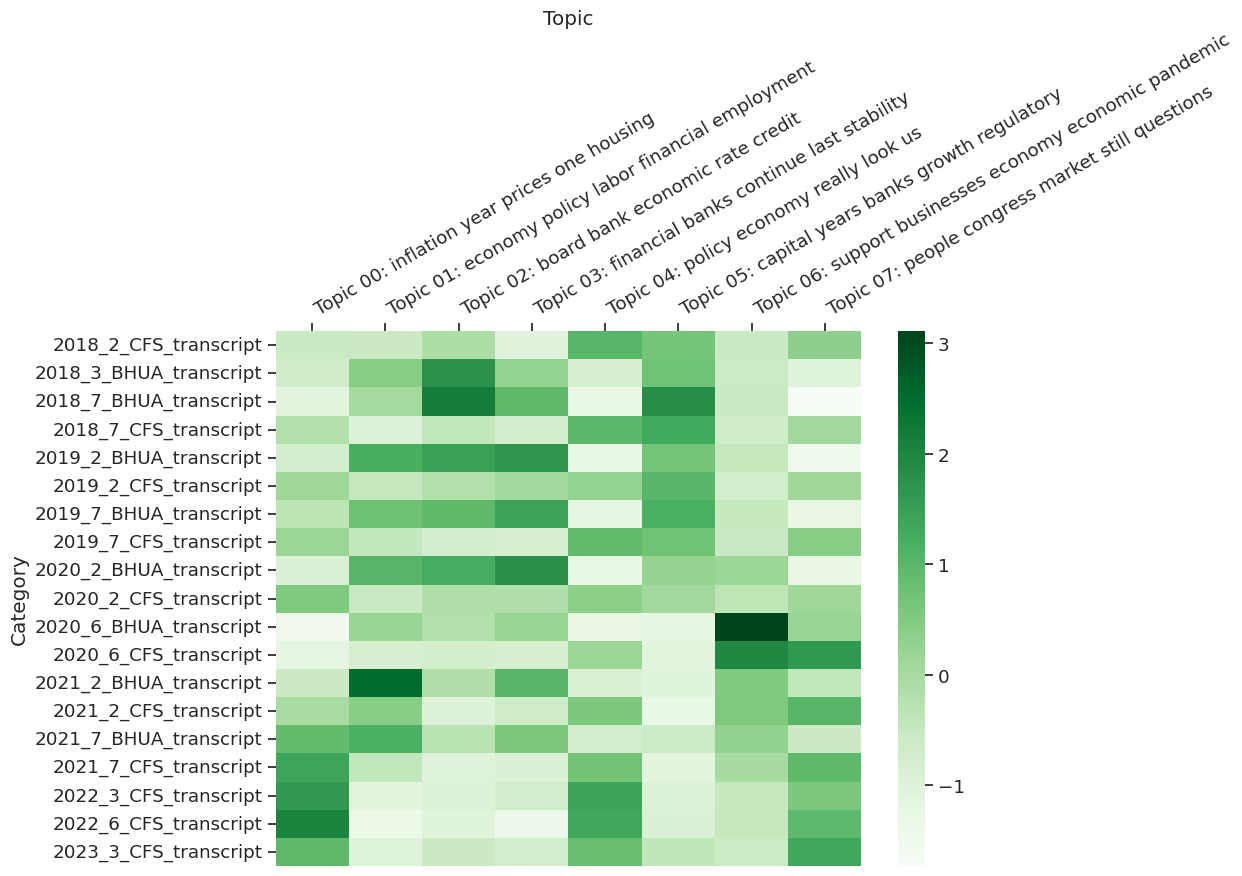

In [67]:
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map = 'Greens',
                                 dim=(12,9))

In [80]:
get_top_docs(titles, topic_distributions, topic_index=6, n=4)

### Topic 6

support businesses economy economic pandemic unemployment work street

---

  
**Topic Probability**: 0.3433426320552826  
**Document**: 2020_6_BHUA_transcript



  
**Topic Probability**: 0.2536140978336334  
**Document**: 2020_6_CFS_transcript



  
**Topic Probability**: 0.14050175249576569  
**Document**: 2021_2_CFS_transcript



  
**Topic Probability**: 0.1386437714099884  
**Document**: 2021_2_BHUA_transcript



In [84]:
get_top_docs(titles, topic_distributions, topic_index=5, n=4)

### Topic 5

capital years banks growth regulatory trade wage good

---

  
**Topic Probability**: 0.2141627073287964  
**Document**: 2018_7_BHUA_transcript



  
**Topic Probability**: 0.1839672029018402  
**Document**: 2018_7_CFS_transcript



  
**Topic Probability**: 0.17576470971107483  
**Document**: 2019_7_BHUA_transcript



  
**Topic Probability**: 0.16662447154521942  
**Document**: 2019_2_CFS_transcript



In [82]:
get_top_docs(titles, topic_distributions, topic_index=0, n=4)

### Topic 0

inflation year prices one housing price high things

---

  
**Topic Probability**: 0.2573869526386261  
**Document**: 2022_6_CFS_transcript



  
**Topic Probability**: 0.23254284262657166  
**Document**: 2022_3_CFS_transcript



  
**Topic Probability**: 0.22140532732009888  
**Document**: 2021_7_CFS_transcript



  
**Topic Probability**: 0.194954514503479  
**Document**: 2023_3_CFS_transcript



###TF-IDF

Using TF-IDF to identify the most significant words featured in the March 2023 CFS questions, we see some  differences in the questions asked by Democrats versus Republicans.

Democrat's top keyword was 'inflation', while Republican's top keyword was 'policy'. At a high level, the most frequent words and most of the words identified using TF-IDF appear to relate to the Fed's mandate to some extent.

Republicans were more likely to ask questions related to fiscal policy. Using the concordance tool, we see that some of the questions were related to Biden administration policies or the impact of fiscal policy on inflation. Democrats were more likely to ask about the debt limit, highlighting the costs associated with not raising it. Both of these topic areas could be classed as relating to political or fiscal matters that cannot be addressed under the Fed's mandate.

Both parties addressed climate change, but the parties approached the topic differently. Democrat questions appeared to focus more on the costs of climate change, while Republicans were more focused on regulation or capital markets. Chair Powell has [stated](https://www.federalreserve.gov/newsevents/pressreleases/powell-statement-20231024b.htm#:~:text=The%20Federal%20Reserve%20has%20narrow,financial%20risks%20of%20climate%20change.) that the Fed's responsibilities regarding climate-related financial risks are narrow, and related to its bank supervision responsibilities.

Republicans also asked about the CFPB - the [Consumer Finance Protection Bureau](https://www.federalregister.gov/agencies/consumer-financial-protection-bureau) - an independent bureau within the Federal Reserve System. The questions appear to relate to the accountability and funding mechanisms of the Bureau. In 2022, the Fifth Circuit Court of Appeals ruled that the CFPB's structure is unconstitutional because it is funded through fees collected by the Fed, instead of through an annual congressional appropriation (Source: [NPR](https://www.npr.org/2023/10/03/1203416483/most-supreme-court-justices-seemed-inclined-to-uphold-how-cfpb-is-funded)). The case was heard by the Supreme Court in October 2023.

In [69]:
##Plotting the TF-IDF Results
##Reference: Krisel 2023, https://github.com/rskrisel/tf-idf/blob/main/README.md

import altair as alt
import numpy as np

# Terms in this list will get a red dot in the visualization
#term_list = ['inflation', 'employment']

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

# red circle over terms in above list
#circle = base.mark_circle(size=100).encode(
#    color = alt.condition(
#        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
#        alt.value('red'),
#        alt.value('#FFFFFF00')
#    )
#)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + text).properties(width = 600)

alt.LayerChart(...)

###Other Text Analysis

The following NLTK tools helped me to place the key words identified above into the broader context of the questions asked (concordance) and showed the most frequency used words (frequency distribution).

In [85]:
##Convert to Text type for concordance
cleanQtext = nltk.Text(Qtext_stops)
cleanRtext = nltk.Text(Rtext_stops)
cleanDtext = nltk.Text(Dtext_stops)

##Republican questions related to 'fiscal'
cleanRtext.concordance("fiscal")

Displaying 11 of 11 matches:
legated treasury since 1912 engaged fiscal agent testified many times issue cb
g question kennedy yesterday impact fiscal policy relates inflation quote attr
r unleashing american energy factor fiscal policies policymakers factor fiscal
fiscal policies policymakers factor fiscal policies impact inflation looking a
ies impact inflation looking advice fiscal policies stay lawmakers looking fis
cal policies stay lawmakers looking fiscal policy impact inflation 449 steil t
ally next decade showing 14 percent fiscal spend compare national defense 13 p
place 484 okay biden administration fiscal energy policy cost trillions defici
 living almost every aspect society fiscal energy policy work biden administra
g inflation 486 risking stagflation fiscal policy monetary policy working 488 
ates higher percent inflation level fiscal monetary cooperation 495 us greatly


In [86]:
##Democrat questions related to 'debt'
cleanDtext.concordance("debt")

Displaying 16 of 16 matches:
ree february 1st congress must raise debt limit described consequences failing
ces failing perhaps important expert debt limit find concerning recommendation
find concerning recommendation raise debt limit timely manner ignored colleagu
 week may seriously look downgrading debt based escalating brinksmanship obser
g even congress ultimately addresses debt limit last minute history repeating 
y repeating standard poor downgraded debt 2011 republicans last controlled hou
tisan policy center later found 2011 debt limit debate cost us billion higher 
s trump office three times addressed debt ceiling timely manner without holdin
 see congress continues delay action debt limit economy individuals families 3
 somewhat quoted congress must raise debt limit described consequences failing
ation statement made able manipulate debt pay bills coming due another account
many commend ranking member bringing debt limit harm already done economy solv
t rates rise borrowers 

In [89]:
##All questions related to 'climate', including some unallocated
cleanQtext.concordance("climate")

Displaying 23 of 23 matches:
 fact make policy decisions related climate change seen example administration 
ministration turn regulators impose climate policy alternative legislative proc
tive process careful ensuring place climate debate congress ensure regulatory t
atory toolkit shall warped creating climate policy outcomes 116 lucas much appr
rk made one person 206 earlier year climate policymaker however draft principle
icies align values context supposed climate risks appears regulation wants begi
regulation wants begin implementing climate policies seems disconnect statement
tting forward comment 208 regarding climate scenario analysis pilot program boa
equality gender race discrimination climate change recently board proposed guid
ying financial institutions monitor climate change touched little bit ensure pl
ing conspiring 251 heard supposedly climate risk risk climate change 253 affect
 heard supposedly climate risk risk climate change 253 affect banks 255 course 
sad colleag

In [87]:
##Democrat questions related to 'climate'
cleanDtext.concordance("climate")

Displaying 11 of 11 matches:
equality gender race discrimination climate change recently board proposed guid
ying financial institutions monitor climate change touched little bit ensure pl
ing conspiring 251 heard supposedly climate risk risk climate change 253 affect
 heard supposedly climate risk risk climate change 253 affect banks 255 course 
sad colleagues side stick head sand climate change supposed climate change real
k head sand climate change supposed climate change reality real climate change 
upposed climate change reality real climate change costing billions billions do
uick issues wanted start discussing climate especially given announcement janua
 announcement january conduct pilot climate scenario analysis exercise along oc
cise along occ fdic issued proposed climate risk management principles banks at
even though forcing banks encompass climate analysis stress tests many initiati


In [88]:
##Democrat questions related to 'climate'
cleanRtext.concordance("climate")

Displaying 12 of 12 matches:
 fact make policy decisions related climate change seen example administration 
ministration turn regulators impose climate policy alternative legislative proc
tive process careful ensuring place climate debate congress ensure regulatory t
atory toolkit shall warped creating climate policy outcomes 116 lucas much appr
 consensus builder 206 earlier year climate policymaker however draft principle
icies align values context supposed climate risks appears regulation wants begi
regulation wants begin implementing climate policies seems disconnect statement
tting forward comment 208 regarding climate scenario analysis pilot program boa
tic review capital markets engaging climate policy well decision put vice charg
kay stated feel policy implementing climate change 421 climate change policies 
icy implementing climate change 421 climate change policies mandated 423 concer
unity borrow banks conducting pilot climate scenario analysis mandated asked ma


In [91]:
##Republican questions related to 'CFPB'
cleanRtext.concordance("cfpb")

Displaying 9 of 9 matches:
consumer financial protection bureau cfpb gets money run agency 147 basically 
y run agency 147 basically money pay cfpb bills case unless continue borrow ba
sically happen borrow money able pay cfpb bills correct 151 question accountab
51 question accountability assessing cfpb spending dollars 153 blank check tol
consumer financial protection bureau cfpb funding mechanism intricately linked
ked system according title x quarter cfpb director requests amount reasonably 
ating expenses first years existence cfpb course relaxation respect percent ca
opriators chairmanship ever rejected cfpb budget request 358 rose tell us poli
ing 425 banks change another expense cfpb history 12 percent go ratio seem log


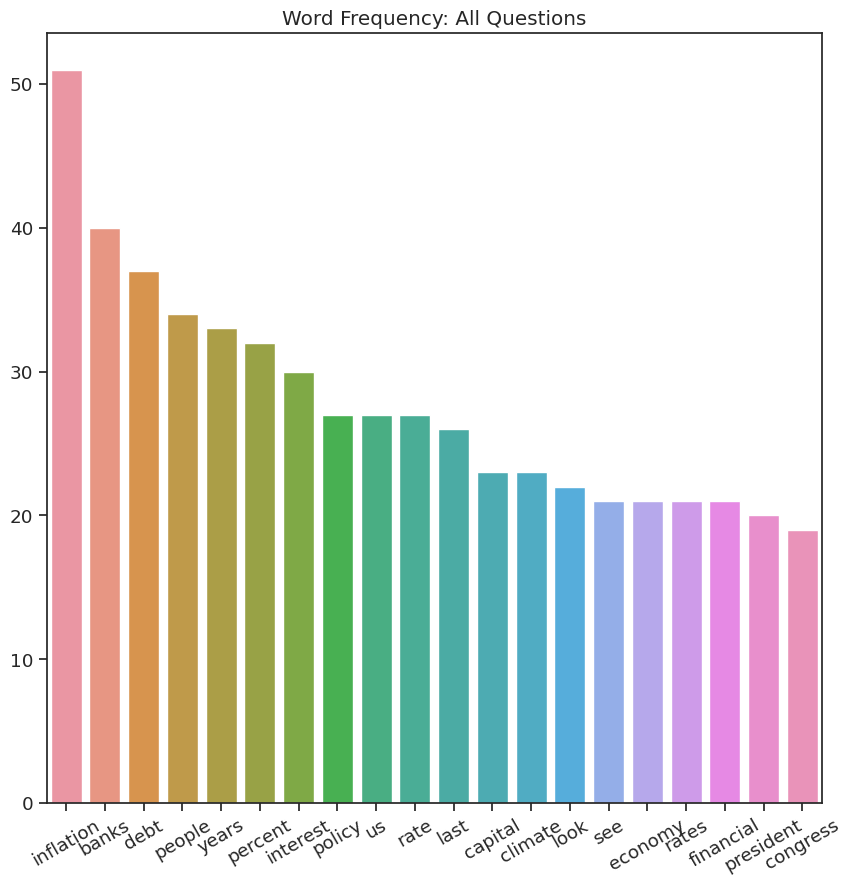

In [95]:
##Frequency Distributions
##Graph code adapted from: https://dariuslfuller.medium.com/creating-visuals-with-nltks-freqdist-ac4e667e49f3
##Title code: https://www.statology.org/seaborn-title/

from nltk import FreqDist

## Creating FreqDist, keeping the 20 most common tokens
Q_dist = FreqDist(Qtext_stops).most_common(20)

## Conversion to Pandas series via Python Dictionary for easier plotting
Q_dist = pd.Series(dict(Q_dist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=Q_dist.index, y=Q_dist.values, ax=ax).set(title='Word Frequency: All Questions')
plt.xticks(rotation=30);

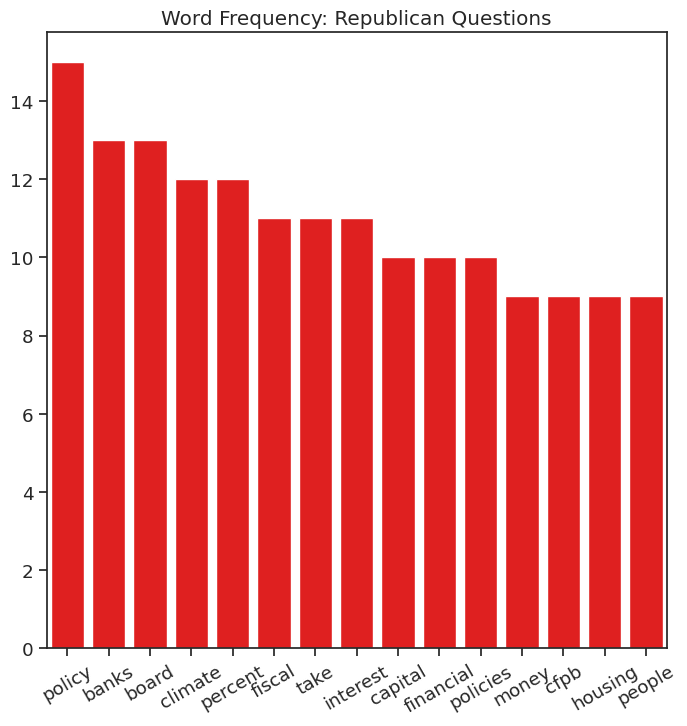

In [75]:
## Creating FreqDist, keeping the 20 most common tokens
R_dist = FreqDist(Rtext_stops).most_common(15)

## Conversion to Pandas series via Python Dictionary for easier plotting
R_dist = pd.Series(dict(R_dist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(8,8))

##code to change graph colour from: https://www.statology.org/seaborn-barplot-color/

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=R_dist.index, y=R_dist.values, ax=ax, color='red').set(title='Word Frequency: Republican Questions')
plt.xticks(rotation=30);

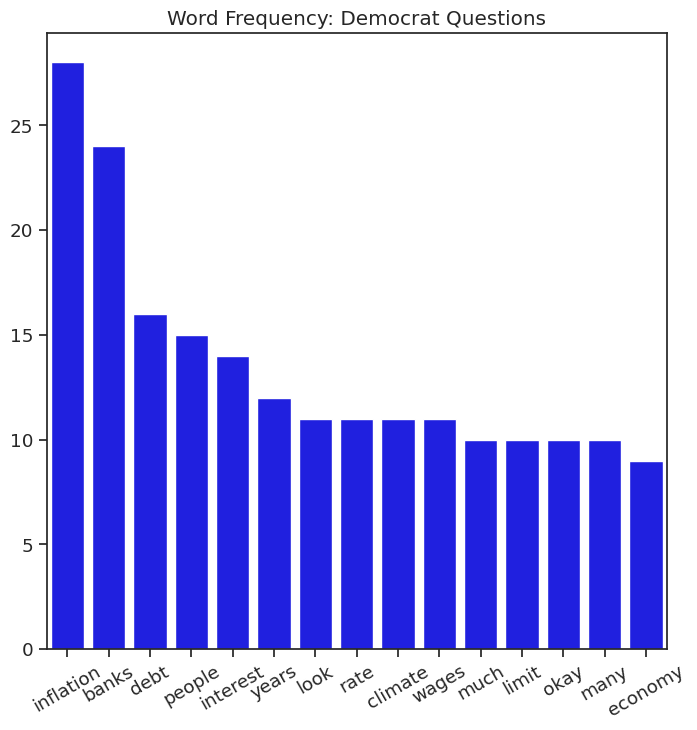

In [76]:
## Creating FreqDist, keeping the 20 most common tokens
D_dist = FreqDist(Dtext_stops).most_common(15)

## Conversion to Pandas series via Python Dictionary for easier plotting
D_dist = pd.Series(dict(D_dist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(8,8))

##code to change graph colour from: https://www.statology.org/seaborn-barplot-color/

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=D_dist.index, y=D_dist.values, ax=ax, color='blue').set(title='Word Frequency: Democrat Questions')
plt.xticks(rotation=30);

##Conclusion

Returning to the research question and hypotheses, how well does Congress hold the Fed to account?

1. Are the questions asked during the testimony ‘relevant’ for the Fed Chair?

Hypothesis: The majority of the questions will relate to monetary policy, inflation, or unemployment.

Result: there was a strong focus on inflation, banks, wages, interest rates and the economy in the transcripts. Overall, it appears that the majority of the discussion in the hearings overall and in the Q&A was related to areas directly under the Fed's mandate.

2. Do the topics of questions asked differ across the two political parties?

Hypothesis: Republicans and Democrats focus on different topics.

Result: the questions asked do differ across the political parties, and where the topics or keywords were similar, the parties approached the questions from different perspectives. Both parties asked questions of the Fed Chair in areas that were not under the Fed's mandate, particularly related to fiscal policy or the debt ceiling. These questions would be better directed to the Treasury Secretary, who is more directly responsible for these areas.

###Next Steps

Further research could be conducted on how the questions change over time, to get a more granular result than the topic modelling heatmap. This could be achieved by repeating the TD-IDF analysis over the entire dataset. The results could be used to identify any rising interest in the Fed's role in addressing income inequality, discrimination in the labor market, and climate change.

 The overall analysis could also be repeated for Janet Yellen's term as Fed Chair. It would be interesting to compare how the questions change across political parties over time when committee members are addressing Fed Chairs from different political parties (Powell is a Republican, Yellen is a Democrat).